In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from pathlib import Path

from post.files import parse_metrics_log, parse_job_log
from post.plots import get_figa, plot_metrics, make_axis_great_again, plot_epochs

In [3]:
tesi_folder = Path('~/Scuola/now/thesis').expanduser()
milestones = tesi_folder / 'milestones'
current_milestone = milestones / '29.04_06.05_scaling-up'

human36m_alg_AlgebraicTriangulationNet@05.05.2021-11:13:48 (from /home/stefano/Scuola/now/thesis/milestones/29.04_06.05_scaling-up/15028470.out)
training on 12, evaluating on 5
found 1000 epochs
training loss in [10143.0, 84723.9]
training metrics in [120.2, 38839.3]
eval metrics in [227.3, 478.0]
- plotted "geo (min = 2.1, last = 2.2)" metrics [0.0, 1.0] in epochs [0, 999]
- plotted "trans (min = 4.9, last = 6.6)" metrics [0.0, 1.0] in epochs [0, 999]
- plotted "pose (min = 5071.5, last = 5383.0)" metrics [0.0, 1.0] in epochs [0, 999]
- plotted "training metrics" metrics [120.2, 38839.3] in epochs [0, 999]
- plotted "eval metrics" metrics [227.3, 478.0] in epochs [0, 999]
human36m_alg_AlgebraicTriangulationNet@05.05.2021-14:21:33 (from /home/stefano/Scuola/now/thesis/milestones/29.04_06.05_scaling-up/15029031.out)
training on 12, evaluating on 5
found 691 epochs
training loss in [69542.4, 102234.4]
training metrics in [454.0, 38766.4]
eval metrics in [490.1, 890.3]
- plotted "geo (min

Text(0.5, 0.98, 'cam2cam estimation (12 / 5 train / validation images), optimizing just last 3 layers of BB, lr BB=1e-6, using predicted KP')

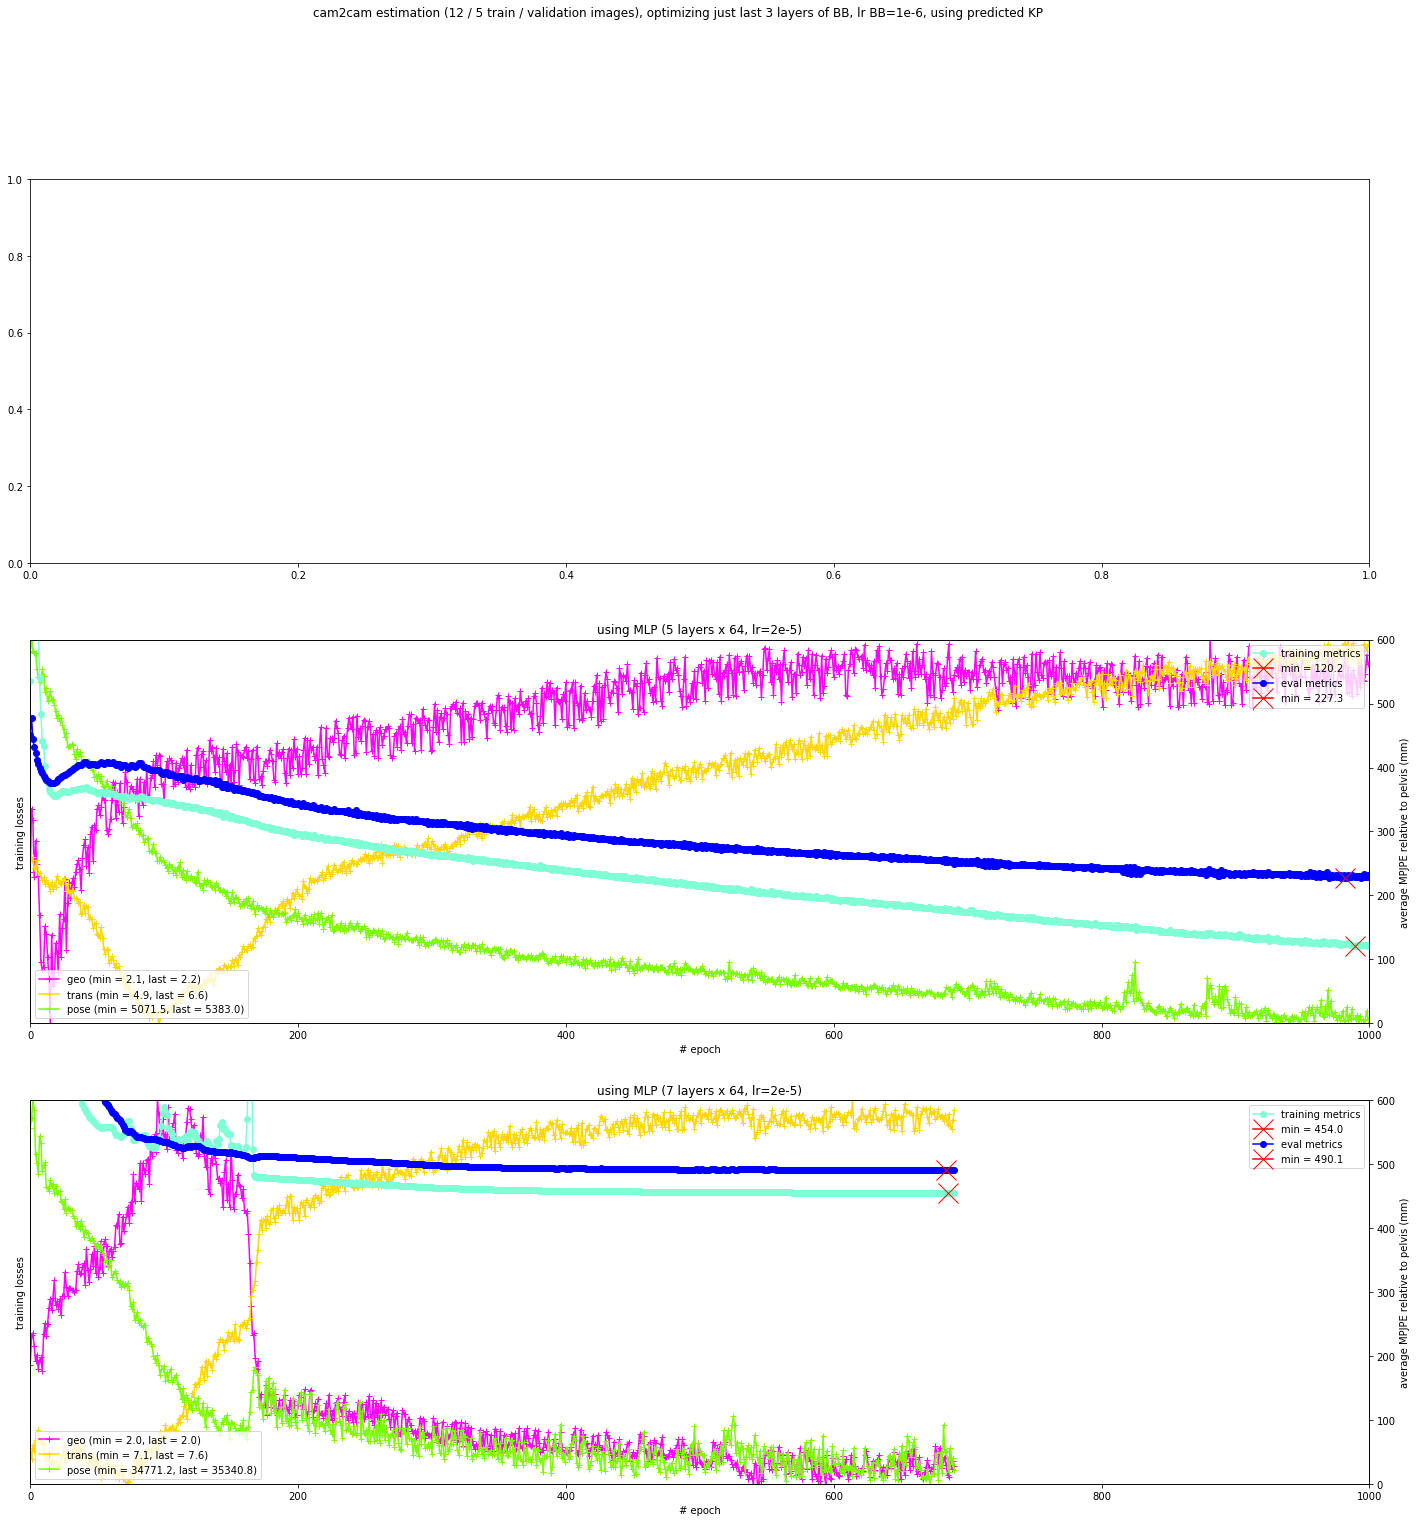

In [10]:
fig, axis = get_figa(3, 1, heigth=8, width=24)
metrics_ylim = [0, 600]
max_epochs = 1000

job_id = '15034704'
# exp_name, train_data_amount, eval_data_amount, epochs = parse_job_log(current_milestone / '{}.out'.format(job_id))
# ax = axis.ravel()[0]
# plot_epochs(
#     ax, epochs,
#     train_metric_ylim=metrics_ylim,
#     eval_metric_ylim=metrics_ylim,
#     loss_ylim=[0, 1e5],
#     title='using MLP (3 layers x 32, lr=2e-5)',
#     metric_ylabel='average MPJPE relative to pelvis (mm)'
# )
ax.set_xlim([0, max_epochs])

job_id = '15028470'
exp_name, train_data_amount, eval_data_amount, epochs = parse_job_log(current_milestone / '{}.out'.format(job_id))
ax = axis.ravel()[1]
plot_epochs(
    ax, epochs,
    train_metric_ylim=metrics_ylim,
    eval_metric_ylim=metrics_ylim,
    loss_ylim=[0, 1e5],
    title='using MLP (5 layers x 64, lr=2e-5)',
    metric_ylabel='average MPJPE relative to pelvis (mm)'
)
ax.set_xlim([0, max_epochs])

job_id = '15029031'
exp_name, train_data_amount, eval_data_amount, epochs = parse_job_log(current_milestone / '{}.out'.format(job_id))
ax = axis.ravel()[2]
plot_epochs(
    ax, epochs,
    train_metric_ylim=metrics_ylim,
    eval_metric_ylim=metrics_ylim,
    loss_ylim=[0, 1e5],
    title='using MLP (7 layers x 64, lr=2e-5)',
    metric_ylabel='average MPJPE relative to pelvis (mm)'
)
ax.set_xlim([0, max_epochs])

fig.suptitle('cam2cam estimation (12 / 5 train / validation images), optimizing just last 3 layers of BB, lr BB=1e-6, using predicted KP')
# cam2cam_proj_VS_geo_loss.png